In [68]:
import numpy as np
import pandas as pd
import time
import datetime
import random
import re
import transformers
import torch
import torch.nn as nn

from nltk.corpus import stopwords
from torch.optim import AdamW
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler,random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from transformers import RobertaForSequenceClassification, get_linear_schedule_with_warmup, RobertaTokenizer

In [69]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [70]:
df = pd.read_pickle("data/codesearchnet_auto.pkl")
len(df)
# export the data to a csv file
df.to_csv('data/codesearchnet_auto.csv', index=False)

In [71]:
df_manual = pd.read_pickle("data/codesearchnet_manual.pkl")
len(df_manual)
# export the data to a csv file
df_manual.to_csv('data/codesearchnet_manual.csv', index=False)

In [72]:
print(df.columns)

Index(['index', 'repo', 'path', 'url', 'code', 'code_tokens', 'docstring',
       'docstring_tokens', 'language', 'partition', 'cosmic_function',
       'cosmic_function_number', 'includes_cosmic_function',
       'includes_cosmic_function_number'],
      dtype='object')


# TRAIN TEST SPLIT

In [73]:
X_train, X_test, y_train, y_test = train_test_split(df['code'], df['cosmic_function_number'], 
                                                    test_size=0.2, random_state=42,
                                                   stratify=df['cosmic_function_number'])

In [74]:
df = pd.DataFrame(data={'code': X_train, 'cosmic_function_number': y_train}).reset_index(drop=True)
test_df = pd.DataFrame(data={'code': X_test, 'cosmic_function_number': y_test}).reset_index(drop=True)
manual_df = pd.DataFrame(data={'code': df_manual['code'], 'cosmic_function_number': df_manual['cosmic_function_number']}).reset_index(drop=True)

In [75]:
display(df)

,code,cosmic_function_number
0,"def show_progress(self):\n """"""If we are...",0
1,"def send_command(self, cmd, sudo=False, stderr...",2
2,def _parse_openssl_req(csr_filename):\n '''...,3
3,"def load_env(keys=[], name='NT', use_getpass=F...",3
4,"def get_setup_version(reponame):\n """"""\n ...",3
...,...,...
3515,"def _combine_w0614(self, messages):\n ""...",3
3516,"def read_block(self, block):\n """"""Read ...",1
3517,"def _append_bytes(self, value, _file): # pyli...",0
3518,"def get_item(self):\n """"""Returns the it...",2


In [76]:
display(test_df)

,code,cosmic_function_number
0,"def process_data(self, fname, tokenizer, max_s...",1
1,"def get(self, name, default=None):\n ''...",3
2,"def log_all(self, file):\n """"""Log all d...",1
3,"def on_consumer_cancelled(self, method_frame):...",2
4,"def open_video(specifier):\n """"""Return an O...",1
...,...,...
875,"def get_nodedata(self, sort_names=False):\n ...",3
876,"def main():\n """"""\n Example application ...",2
877,"def get_or_set_hash(uri,\n length=8,\n ...",0
878,"def to_epw(self, buffer_or_path=None):\n ...",0


In [77]:
display(manual_df)

,code,cosmic_function_number
0,"def remove_old_message():\n """"""\n Remove...",1
1,"def open_stream(stream):\n """"""Opens a strea...",1
2,"def read_json(filename, mode='r'):\n '''rea...",1
3,"def get_sample_trim(p1_data, p2_data):\n """"...",1
4,"def get_data(self):\n """"""\n retu...",1
...,...,...
395,"def _send(self):\n """"""\n Convert...",2
396,"async def reply_voice(self, voice: typing.Unio...",2
397,"async def send_voice(self, chat_id: typing.Uni...",2
398,"def send(self, *args, **kwargs):\n """"""A...",2


In [78]:
REMOVE_COMMENTS = True
COMMENTS_POSTFIX = "with_comments" if not REMOVE_COMMENTS else "without_comments"

def dedoc(a):
    # remove docstrings (between triple quotes or triple double quotes)
    a = re.sub(r'"""(.|\n)*?"""', '', a)
    a = re.sub(r"'''(.|\n)*?'''", '', a)
    if REMOVE_COMMENTS:
        a = re.sub(r'#.*', '', a)
    return a


In [79]:
codes = df.code.apply(dedoc).values
test_codes = test_df.code.apply(dedoc).values
manual_codes = manual_df.code.apply(dedoc).values

In [80]:
tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base")

In [81]:
labels = torch.from_numpy(df.cosmic_function_number.values)
test_labels = torch.from_numpy(test_df.cosmic_function_number.values)
manual_labels = torch.from_numpy(manual_df.cosmic_function_number.values)

In [82]:
max_len = 0
n=0
for code in manual_codes:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(code, add_special_tokens=False, max_length=512, truncation=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))
    if len(input_ids) == 512:
        n+=1

print('Inputs that exceed max limit:', n)

Inputs that exceed max limit: 77


In [83]:
input_ids = []
attention_masks = []

# For every tweet...
for code in codes:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        code,                      # Sentence to encode.
                        add_special_tokens = False, # Add '[CLS]' and '[SEP]'
                        padding = 'max_length',
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = labels.clone().detach()

In [84]:
print(input_ids.shape)

torch.Size([3520, 512])


In [85]:
# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.8 * len(dataset))
#val_size = int(0.2 * len(dataset))
val_size = len(dataset)  - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

2,816 training samples
  704 validation samples


In [86]:
# The DataLoader needs to know our batch size for training, so we specify it
# here. For fine-tuning BERT on a specific task, the authors recommend a batch
# size of 16 or 32.
batch_size = 64

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order.
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [87]:
# Load the pretrained codebert model with a single linear classification layer on top.
model = RobertaForSequenceClassification.from_pretrained(
    "microsoft/codebert-base", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 4, # The number of output labels=2 for binary classification.
                    # You can increase this for multi-class tasks.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

model = model.to(device)

Some weights of the model checkpoint at microsoft/codebert-base were not used when initializing RobertaForSequenceClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be 

In [88]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [89]:
# Number of training epochs. The BERT authors recommend between 2 and 4.
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 5

# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [90]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [91]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

# RUN TRAINING

In [25]:
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
training_stats = []

# Create empty csv to write training statistics
with open(f'training_stats_{COMMENTS_POSTFIX}.csv', 'w') as f:
    f.write('epoch,TrainLoss,ValidLoss,ValidAcc,TrainTime,ValidTime\n')

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.
    print('\n======== Epoch {:} of {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    # Measure how long the training epoch takes.
    t0 = time.time()
    total_train_loss = 0
    model.train()
    for step, batch in enumerate(train_dataloader):
        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the device using the
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        optimizer.zero_grad()
        output = model(b_input_ids,
                             token_type_ids=None,
                             attention_mask=b_input_mask,
                             labels=b_labels)
        loss = output.loss
        total_train_loss += loss.item()
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()
        # Update the learning rate.
        scheduler.step()
        #print(step)

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("\n  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on  our validation set.
    print("\nRunning Validation...")
    t0 = time.time()
    # Put the model in evaluation mode--the dropout layers behave differently during evaluation.
    model.eval()
    # Tracking variables
    total_eval_accuracy = 0
    best_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    # Evaluate data for one epoch
    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():
            output= model(b_input_ids,
                                   token_type_ids=None,
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
        loss = output.loss
        total_eval_loss += loss.item()
        # Move logits and labels to CPU if we are using GPU
        logits = output.logits
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        # Calculate the accuracy for this batch of test sentences, and accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    if avg_val_accuracy > best_eval_accuracy:
        torch.save(model, f'checkpoints/codebert_best_model_{COMMENTS_POSTFIX}.pt')
        best_eval_accuracy = avg_val_accuracy

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'TrainLoss': avg_train_loss,
            'ValidLoss': avg_val_loss,
            'ValidAcc': avg_val_accuracy,
            'TrainTime': training_time,
            'ValidTime': validation_time
        }
    )
    # Append the training statistics to the CSV file
    with open(f'training_stats_{COMMENTS_POSTFIX}.csv', 'a') as f:
        f.write('results/{},{:.4f},{:.4f},{:.4f},{},{}\n'.format(epoch_i + 1, avg_train_loss, 
                                                                 avg_val_loss, avg_val_accuracy, 
                                                                 training_time, validation_time))

print("\nTraining complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 of 5 ========
Training...

  Average training loss: 1.34
  Training epoch took: 0:00:49

Running Validation...
  Accuracy: 0.54

======== Epoch 2 of 5 ========
Training...

  Average training loss: 0.87
  Training epoch took: 0:00:52

Running Validation...
  Accuracy: 0.73

======== Epoch 3 of 5 ========
Training...

  Average training loss: 0.68
  Training epoch took: 0:00:53

Running Validation...
  Accuracy: 0.73

======== Epoch 4 of 5 ========
Training...

  Average training loss: 0.61
  Training epoch took: 0:00:53

Running Validation...
  Accuracy: 0.75

======== Epoch 5 of 5 ========
Training...

  Average training loss: 0.56
  Training epoch took: 0:00:53

Running Validation...
  Accuracy: 0.74

Training complete!
Total training took 0:04:47 (h:mm:ss)


# LOAD AND TEST TRAINED MODEL

In [92]:
model = torch.load(f'checkpoints/codebert_best_model_{COMMENTS_POSTFIX}.pt')
selected_codes = manual_codes
selected_labels = manual_labels

In [93]:
test_input_ids = []
test_attention_masks = []
for code in selected_codes:
    encoded_dict = tokenizer.encode_plus(
                        code,
                        add_special_tokens = True,
                        # max_length = max_len,
                        padding = 'max_length',
                        return_attention_mask = True,
                        return_tensors = 'pt',
                        truncation = True
                   )
    test_input_ids.append(encoded_dict['input_ids'])
    test_attention_masks.append(encoded_dict['attention_mask'])
test_input_ids = torch.cat(test_input_ids, dim=0)
test_attention_masks = torch.cat(test_attention_masks, dim=0)

In [94]:
test_dataset = TensorDataset(test_input_ids, test_attention_masks)
test_dataloader = DataLoader(
            test_dataset, # The validation samples.
            sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# GET PREDICTIONS

In [95]:
predictions = []
for batch in test_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        with torch.no_grad():
            output= model(b_input_ids,
                                   token_type_ids=None,
                                   attention_mask=b_input_mask)
            logits = output.logits
            logits = logits.detach().cpu().numpy()
            pred_flat = np.argmax(logits, axis=1).flatten()

            predictions.extend(list(pred_flat))

In [96]:
df_output = pd.DataFrame()
df_output['code'] = selected_codes
df_output['label'] = selected_labels
df_output['prediction'] = predictions
df_output.to_csv(f'results/predictions_{len(df_output)}_{COMMENTS_POSTFIX}.csv',index=False)

In [97]:
display(df_output)

,code,label,prediction
0,def remove_old_message():\n \n global g_...,1,3
1,def open_stream(stream):\n \n global str...,1,1
2,"def read_json(filename, mode='r'):\n \n ...",1,1
3,"def get_sample_trim(p1_data, p2_data):\n \n...",1,3
4,def get_data(self):\n \n with se...,1,1
...,...,...,...
395,def _send(self):\n \n while len(...,2,2
396,"async def reply_voice(self, voice: typing.Unio...",2,2
397,"async def send_voice(self, chat_id: typing.Uni...",2,2
398,"def send(self, *args, **kwargs):\n \n ...",2,2


In [98]:
acc = np.sum(df_output['label'] == df_output['prediction']) / len(df_output['label'])
print(acc)

0.845


In [99]:
from sklearn.metrics import classification_report


target_names = ['W', 'R', 'X', 'E']
print(classification_report(df_output['label'], df_output['prediction'], target_names=target_names, digits=4))
# write to txt file
with open(f'results/classification_report_{len(df_output)}_{COMMENTS_POSTFIX}.txt', 'w') as f:
    f.write(classification_report(df_output['label'], df_output['prediction'], target_names=target_names, digits=4))

from sklearn.metrics import confusion_matrix


print(confusion_matrix(df_output['label'], df_output['prediction']))
# append to txt file
with open(f'results/classification_report_{len(df_output)}_{COMMENTS_POSTFIX}.txt', 'a') as f:
    f.write(str(confusion_matrix(df_output['label'], df_output['prediction'])))



              precision    recall  f1-score   support

           W     0.8800    0.8800    0.8800       100
           R     0.8065    0.7500    0.7772       100
           X     0.8796    0.9500    0.9135       100
           E     0.8081    0.8000    0.8040       100

    accuracy                         0.8450       400
   macro avg     0.8435    0.8450    0.8437       400
weighted avg     0.8435    0.8450    0.8437       400

[[88 10  1  1]
 [ 7 75  5 13]
 [ 0  0 95  5]
 [ 5  8  7 80]]


# plot confusion matrix


[[88 10  1  1]
 [ 7 75  5 13]
 [ 0  0 95  5]
 [ 5  8  7 80]]


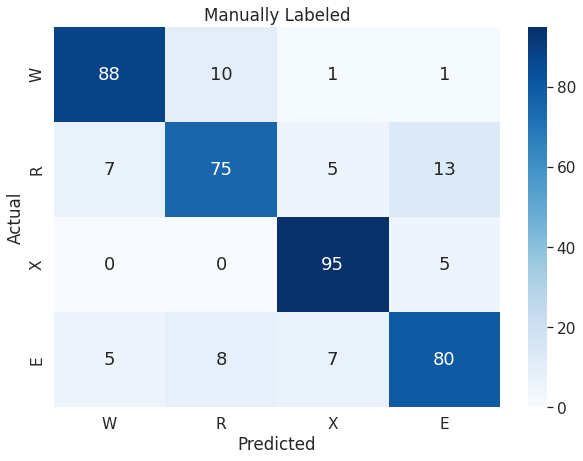

In [100]:
# plot confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np

# read matrix from classification report txt file

with open(f'results/classification_report_{len(df_output)}_{COMMENTS_POSTFIX}.txt', 'r') as f:
    file_content = f.read()
    # get text between [[ and ]]
    matrix = file_content[file_content.find('[[')+1:file_content.find(']]')+1]
    # remove [ and ]
    matrix = matrix.replace('[', '').replace(']', '')
    # split by space or multiple spaces
    matrix = re.split(r'\s+', matrix)
    # convert to numpy matrix
    matrix = np.array(matrix).astype(int).reshape(4, 4)
    
print(matrix)
target_names = ['W', 'R', 'X', 'E']

# set font size
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(10,7))
plt.title('Manually Labeled')
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig(f'results/confusion_matrix_{len(df_output)}_{COMMENTS_POSTFIX}.png', dpi=300, bbox_inches='tight')
plt.show()

